In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
#Находим категориальные признаки
cat_feats = list(df.dtypes[df.dtypes == object].index)

In [4]:
#выберем непрерывные признаки
num_feats = [f for f in df if f not in (cat_feats + ['ID', 'SalePrice'])]

In [5]:
# заполним пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df[cat_feats] = df[cat_feats].fillna('nan')

In [6]:
# Заменяем пропуски на медиану
df_median = df[num_feats].median()

In [7]:
# Создаем дамми-переменные для категорий
dummy_feats = pd.get_dummies(df[cat_feats], columns=cat_feats)

In [8]:
X = pd.concat([df[num_feats].fillna(df_median),
                     df[num_feats + cat_feats].isnull().astype(np.int8).add_suffix('_NaN'), dummy_feats], axis=1)

In [9]:
y = df['SalePrice']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
# построим случайный лес
model_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, bootstrap=True, random_state=0)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [34]:
# посмотрим на результат
print(f"MSE = {np.mean(-cross_val_score(model_rf,X_test,y_test,cv=10,scoring='neg_mean_squared_error'))}")

MSE = 1850382085.1993186


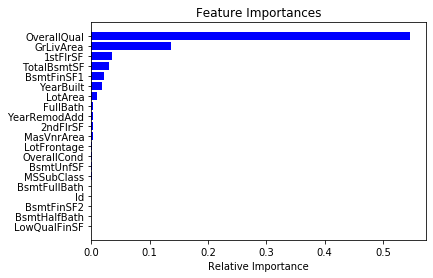

In [13]:
# Важность признаков
features = X_train.columns
imp = model_rf.feature_importances_[0:20]

indices = np.argsort(imp)

plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [14]:
# Обучим XGBoost
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
print(model)
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      178438.625000      284.025039   178459.958333     382.353082
1      162012.333333      223.262399   162207.364583      73.066575
2      147265.187500      185.454409   147510.791667     325.210696
3      134048.552083      132.245488   134392.755208     515.931987
4      122219.286459      110.490482   122630.190105     839.788150
..               ...             ...             ...            ...
495      8979.632487      248.977566    27663.175130    4816.720168
496      8971.712891      250.469605    27660.999349    4817.258353
497      8964.070638      244.668931    27664.521484    4813.388758
498      8950.655274      244.405049    27668.936198    4815.486368
499      8937.524089      242.474607    27671.089193    4810.547571

[500 rows x 4 columns]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=360, n_jobs=4,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [35]:
print(f"MSE = {np.mean(-cross_val_score(model_xgb,X_test,y_test,cv=10,scoring='neg_mean_squared_error'))}")

MSE = 1635120698.508711


In [16]:
# Обучим линейную регрессию
from sklearn.preprocessing import StandardScaler

In [17]:
X_train_lin = X_train.copy()
X_test_lin = X_test.copy()

In [18]:
scaler = StandardScaler()
scaler.fit(X_train_lin[num_feats])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
X_train_lin[num_feats] = scaler.transform(X_train_lin[num_feats])
X_test_lin[num_feats] = scaler.transform(X_test_lin[num_feats])

In [20]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_lin, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
print(f"MSE = {np.mean(-cross_val_score(model_lr,X_test,y_test,cv=10,scoring='neg_mean_squared_error'))}")

MSE = 3418258164.2647905


# Стекинг

In [23]:
# Смешаем дерево, линейную регрессию и XGBoost

In [24]:
type(y_test)

pandas.core.series.Series

In [25]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [37]:
from sklearn.model_selection import KFold

stack_cv = KFold(n_splits=10, random_state=0)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(model_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(model_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('XGB features...')
meta_tr, meta_te = get_meta_features(model_xgb, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('xgb_pred')

C:\Users\BEU_RU1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR features...
RF features...
XGB features...


In [38]:
# Стэкинг мета-признаков с помощью LR
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [39]:
model_lr_meta = LinearRegression(n_jobs=-1)
model_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [40]:
y_pred_meta_test = model_lr_meta.predict(X_meta_test)
print(f"MSE = {np.mean(-cross_val_score(model_lr,X_meta_test,y_pred_meta_test,cv=10,scoring='neg_mean_squared_error'))}")

MSE = 8.302330314290839e-21


В результате, использование ансамблей моделей действительно улучшает качество.

In [41]:
y_pred_meta_test

array([234511.67298419, 150770.67706376, 110058.08345084, 221286.10885491,
        88329.03827454,  87915.54899287, 268308.3154149 , 122704.3416469 ,
       397735.57542169, 161271.69375317, 199005.66353753, 140791.53792878,
       229942.66890853, 129896.80884604, 121442.02964974, 145784.72268957,
       228172.98536803, 124531.7609187 , 134012.11669124, 190042.76357625,
       120856.85270676, 151188.55241709, 106307.25325472, 160220.68414966,
       184470.47177   , 198960.33980054, 165861.80131631,  81226.88733555,
       338466.30898062, 111468.34003279, 138153.31150668, 199854.72420441,
       151619.52963583, 300787.34581106, 368106.2042123 , 195741.83787834,
       290178.1140114 , 116808.67328895, 230146.9103342 , 318694.12102841,
       206629.41451078, 118483.11395825, 190857.48337299, 307573.58084666,
       348280.79900724, 129307.4144773 , 124534.09674163, 126368.09844964,
       169475.11650492,  96766.0579933 , 404931.41351324, 144784.36658365,
       158141.28607948,  

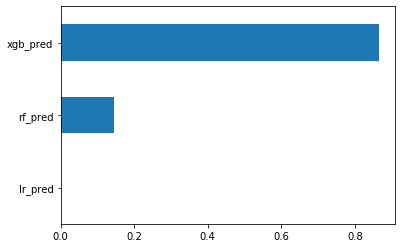

In [42]:
#Посмотрим на коэффициенты объединяющей линейной модели
pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

XGBoost важнее всех!